# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
from collections import deque
import matplotlib.pyplot as plt

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk
import networkx as nx

# Setting

In [4]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 10000

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [5]:
setting = Setting()

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Functions

### Load all data

In [6]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            # ground truth of betweenness centrality
            p = os.path.join(path, f)
            between.append(p)
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)

    between.sort()
    edge_index.sort()
    
    return edge_index, between

### Split Data

In [7]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)

### Cvt 2 dataloader

In [8]:
def to_dataloader(x, y, batch):
    
    data_list = []
    for index, f in enumerate(x):
        edge_index = torch_geometric.io.read_txt_array(f, dtype=torch.long)
        edge_index = edge_index.t().contiguous()
        edge_index = utils.to_undirected(edge_index)

        row, col = edge_index  
        deg = utils.degree(col) # must use col to get degree, why?
        deg = deg.numpy()  

        vertice = []
        for d in deg:
            vertice.append([d, 1, 1])
        vertice = np.array(vertice, dtype=np.float)
        vertice = torch.from_numpy(vertice)

        ### between centrality
        bcs = []
        bc = torch_geometric.io.read_txt_array(y[index], dtype=torch.double)
        bc = bc.t().contiguous()
        row, col = bc
        bc = col
        bc = bc.numpy()
        
        bcs = torch.from_numpy(
                    np.array([[b] for b in bc], dtype=np.float))

        data = Data(x=vertice, edge_index=edge_index, y=bcs)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return data_list

### Cvt 2 Data

In [9]:
def to_data(x, y=None, x_sep=None, y_sep=None):
    
    if x_sep is not None:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long, sep=x_sep)
    else:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    if y is not None:
        ### between centrality
        bcs = []
        if y_sep is not None:
            bc = torch_geometric.io.read_txt_array(y, dtype=torch.double, sep=y_sep)
        else:
            bc = torch_geometric.io.read_txt_array(y, dtype=torch.double)
        bc = bc.t().contiguous()
        row, col = bc
        bc = col
        bc = bc.numpy()
        bcs = torch.from_numpy(
                np.array([[b] for b in bc], dtype=np.float))

        data = Data(x=vertice, edge_index=edge_index, y=bcs)
        
    else:
        data = Data(x=vertice, edge_index=edge_index)
    
    return data

### Cvt nx.Graph 2 PyG.Data

In [10]:
def from_networkx(G, between_list=None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    
    if between_list is not None:
        data['y'] = torch.from_numpy(
            np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

## Read data

### Load all data

In [11]:
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

In [12]:
split_data(path=setting.data_split, x=synthetic, y=between)

### Read train/test/valid

In [13]:
f = open(setting.data_split, 'r')
data_split = json.load(f)

X_train = data_split["X_train"]
X_valid = data_split["X_valid"]
X_test = data_split["X_test"]
y_train = data_split["y_train"]
y_valid = data_split["y_valid"]
y_test = data_split["y_test"]

f.close()

### Cvt to data/dataloader

In [14]:
train_loader = to_dataloader(X_train, y_train, batch=1)
valid_loader = to_dataloader(X_valid, y_valid, batch=1)
test_loader = to_dataloader(X_test, y_test, batch=1)

In [15]:
all_loader = to_dataloader(synthetic, between, batch=1)

In [41]:
yt_data = to_data(yt[0], yt_score[0], y_sep=r":")

# Model

## Hyper params

In [16]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

setting.params_node2vec = dict(
    in_features = 128
)

## DrBC

In [17]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [18]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [19]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [20]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [21]:
import node2vec
from gensim.models import Word2Vec

INFO:gensim.summarization.textcleaner:'pattern' package not found; tag filters are not available for English


In [22]:
def learn_embeddings(walks, dim=128, window=10, workers=8, iters=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=dim, window=window, min_count=0, sg=1, workers=workers, iter=iters)
    
    return model.wv



def gnx_to_emb(G, nodes_cnt):
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

    G = node2vec.Graph(G, False, p=1, q=1)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(10, 80)

    embs = learn_embeddings(walks)
    embs_ = []
    for index in range(nodes_cnt):
        embs_.append(torch.from_numpy(np.array(embs.get_vector(str(index)), dtype=np.float)))
    embs_ = torch.stack(embs_)
    
    
    return embs_

In [23]:
class BC_node2vec(nn.Module):
    
    def __init__(self, in_features):
        super().__init__()

        self.mlp = nn.Linear(in_features=in_features, out_features=1).double()
        
    def forward(self, emb):
        
        return self.mlp(emb)

# Evaluation

## Top k %

In [24]:
def top_n_percentage(bc_gt, bc_pr, k):
    
    if not isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.from_numpy(bc_gt)
    bc_gt = bc_gt.to(setting.device)
    bc_gt = torch.reshape(bc_gt, (-1, ))
    
    if not isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.from_numpy(bc_pr)
    bc_pr = bc_pr.to(setting.device)
    bc_pr = torch.reshape(bc_pr, (-1, ))
    
    nodes = bc_gt.size()[0]
    k = int(nodes * k / 100)
    
    gt_value, gt_indice = torch.topk(bc_gt, k)
    pr_value, pr_indice = torch.topk(bc_pr, k)

    gt_indice = set(gt_indice.cpu().numpy())
    pr_indice = set(pr_indice.cpu().numpy())

    intersect = len(gt_indice & pr_indice)
    top = intersect/k
    
    return top

## Tau Kendal

In [25]:
from scipy import stats

def kendal_tau_distance(bc_gt, bc_pr):
    
    if isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.reshape(bc_gt, (-1, ))
        bc_gt = bc_gt.cpu().detach().numpy()
        
    if isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.reshape(bc_pr, (-1, ))
        bc_pr = bc_pr.cpu().detach().numpy()
    
    tau, p_value = stats.kendalltau(bc_gt, bc_pr)
    return tau

## Evaluation Mode

In [26]:
def eval_model(model, data, bc_gt):
    
    with torch.no_grad():
        data = data.to(setting.device)
        bc_pr = model(data)

#         bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]

        # random sample 5|V| nodes
        src = (torch.rand(nodes * 5) * (nodes-1)).long()
        det = (torch.rand(nodes * 5) * (nodes-1)).long()

        y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
        y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

        y_gt = nn.Sigmoid()(y_gt)
        y_pr = nn.Sigmoid()(y_pr)

        loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)
        
        return loss.item(), bc_pr

# Train

## Load model

In [30]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

In [106]:
model, optimizer = load_checkpoint(
                    setting.weight_node2vec,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

model

use a new optimizer


BC_node2vec(
  (mlp): Linear(in_features=128, out_features=1, bias=True)
)

## DrBC

In [ ]:
nodes_cnt = 5000


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    # Convert networkx.Graph to Pyg Data
    pyg_data = from_networkx(G, between_list)
    print("\nEpoch: {}".format(epoch+1))
    
    
    ### Start training
    optimizer.zero_grad()

    pyg_data = pyg_data.to(setting.device)
    bc_pr = model(pyg_data)

    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
#         emb = gnx_to_emb(G, nodes_cnt)
#         emb = emb.to(setting.device)
#         bc_pr = model(pyg_data)
        
        loss, bc_pr = eval_model(model, pyg_data, bc_gt)
        
        top1 = top_n_percentage(bc_gt, bc_pr, k=1)
        top5 = top_n_percentage(bc_gt, bc_pr, k=5)
        top10 = top_n_percentage(bc_gt, bc_pr, k=10)
        kendal = kendal_tau_distance(bc_gt, bc_pr)

        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                loss,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(loss)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)



        ### Evaluation:- Synthetic
        bce_l = []
        top1_l = []
        top5_l = []
        top10_l = []
        kendal_l = []

        for data in all_loader:
            
            loss, bc_pr = eval_model(model, data, data.y)
            
            bce_l.append(loss)
            top1_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            top5_l.append(top_n_percentage(bc_gt, bc_pr, k=5))
            top10_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            kendal_l.append(kendal_tau_distance(bc_gt, bc_pr))

        bce = sum(bce_l)/len(bce_l)
        top1 = sum(top1_l)/len(top1_l)
        top5 = sum(top5_l)/len(top5_l)
        top10 = sum(top10_l)/len(top10_l)
        kendal = sum(kendal_l)/len(kendal_l)

        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            bce,
            top1,
            top5,
            top10,
            kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)


        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }


Epoch: 1
Train: loss = 17328.681817183424, top 1 = 0.92, top 5 = 0.84, top 10 = 0.746, kendal = 0.7468194438887777
Valid: loss = 17328.69308357833, top 1 = 0.636, top 5 = 0.6187999999999999, top 10 = 0.6415333333333334, kendal = 0.4567827058745083

Epoch: 2
Train: loss = 17328.672852006828, top 1 = 0.86, top 5 = 0.76, top 10 = 0.584, kendal = 0.6932236047209441
Valid: loss = 17328.678468844235, top 1 = 0.632, top 5 = 0.6170666666666668, top 10 = 0.6380666666666667, kendal = 0.471629451223578

Epoch: 3
Train: loss = 17328.668453861283, top 1 = 0.86, top 5 = 0.728, top 10 = 0.538, kendal = 0.5157101820364073
Valid: loss = 17328.672009743066, top 1 = 0.6326666666666667, top 5 = 0.6165333333333335, top 10 = 0.6337333333333334, kendal = 0.47577902247116083

Epoch: 4
Train: loss = 17328.66575137698, top 1 = 0.9, top 5 = 0.7, top 10 = 0.522, kendal = 0.42890930186037207
Valid: loss = 17328.668630279673, top 1 = 0.6433333333333334, top 5 = 0.6184, top 10 = 0.6296666666666668, kendal = 0.47144

## Node2Vec

In [107]:
nodes_cnt = 5000


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    emb = gnx_to_emb(G, nodes_cnt)
    
    ### Start training
    optimizer.zero_grad()

    emb = emb.to(setting.device)
    bc_pr = model(emb)


    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
#         emb = gnx_to_emb(G, nodes_cnt)
#         emb = emb.to(setting.device)
#         bc_pr = model(emb)
        
        loss, bc_pr = eval_model(model, emb, bc_gt)
        
        top1 = top_n_percentage(bc_gt, bc_pr, k=1)
        top5 = top_n_percentage(bc_gt, bc_pr, k=5)
        top10 = top_n_percentage(bc_gt, bc_pr, k=10)
        kendal = kendal_tau_distance(bc_gt, bc_pr)

        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                loss,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(loss)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)



        ### Evaluation:- Synthetic
        bce_l = []
        top1_l = []
        top5_l = []
        top10_l = []
        kendal_l = []

        for data in all_loader:
            
            G = utils.to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)
            emb = gnx_to_emb(G)
            
            loss, bc_pr = eval_model(model, emb, data.y)
            
            bce_l.append(loss)
            top1_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            top5_l.append(top_n_percentage(bc_gt, bc_pr, k=5))
            top10_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            kendal_l.append(kendal_tau_distance(bc_gt, bc_pr))

        bce = sum(bce_l)/len(bce_l)
        top1 = sum(top1_l)/len(top1_l)
        top5 = sum(top5_l)/len(top5_l)
        top10 = sum(top10_l)/len(top10_l)
        kendal = sum(kendal_l)/len(kendal_l)

        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            bce,
            top1,
            top5,
            top10,
            kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)


        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            torch.save(checkpoint, setting.weight_node2vec)
            top_10 = top10

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 800000 words, keeping 5000 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 1600000 words, keeping 5000 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 2400000 words, keeping 5000 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 3200000 words, keeping 5000 word types
INFO:gensim.models.word2vec:collected 5000 word types from a corpus of 4000000 raw words and 50000 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=0 retains 5000 unique words (100% of original 5000, drops 0)
INFO:gensim.models.word2vec:effective_min_count=0 leaves 4000000 word corpus (100% of original 4000000, drops 0)
INFO:gensim.models.word2vec

AttributeError: 'float' object has no attribute 'item'

# Visualization

In [ ]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        if key == "bce":
            y_train = [v/nodes_cnt for v in train[key]]
            y_valid = [v/5000 for v in valid[key]]
            ax.plot(x, y_train, color="blue")
            ax.plot(x, y_valid, color="orange")            
        else:
            ax.plot(x, train[key], color="blue")
            ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Compare diff scale

In [33]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

weight: 3000.pth
pretrained finded
weight: 300.pth
pretrained finded
weight: 1200.pth
pretrained finded
weight: 5000.pth
pretrained finded
weight: 200.pth
pretrained finded



top1
scale=200, mean=0.6606666666666666, std=0.16374641641541007
scale=300, mean=0.6593333333333333, std=0.16301192867053899
scale=1200, mean=0.66, std=0.16403251710153893
scale=3000, mean=0.6833333333333336, std=0.17220788470785986
scale=5000, mean=0.636, std=0.1423985018647785

top5
scale=200, mean=0.6389333333333334, std=0.1302343869934341
scale=300, mean=0.6376000000000002, std=0.12988856762625414
scale=1200, mean=0.6573333333333333, std=0.13822236513032984
scale=3000, mean=0.6728, std=0.15371454062644824
scale=5000, mean=0.6188, std=0.12861166354572975

top10
scale=200, mean=0.6447333333333333, std=0.11378047088826604
scale=300, mean=0.6474000000000001, std=0.11626423927129671
scale=1200, mean=0.6700666666666667, std=0.12222763826383769
scale=3000, mean=0.6585333333333332, std=0.13130314373828053
scale=5000, mean=0.6415333333333334, std=0.11461783844100747

kendal
scale=200, mean=0.4162531066213242, std=0.11592136297554113
scale=300, mean=0.34002063879442557, std=0.10374069606698

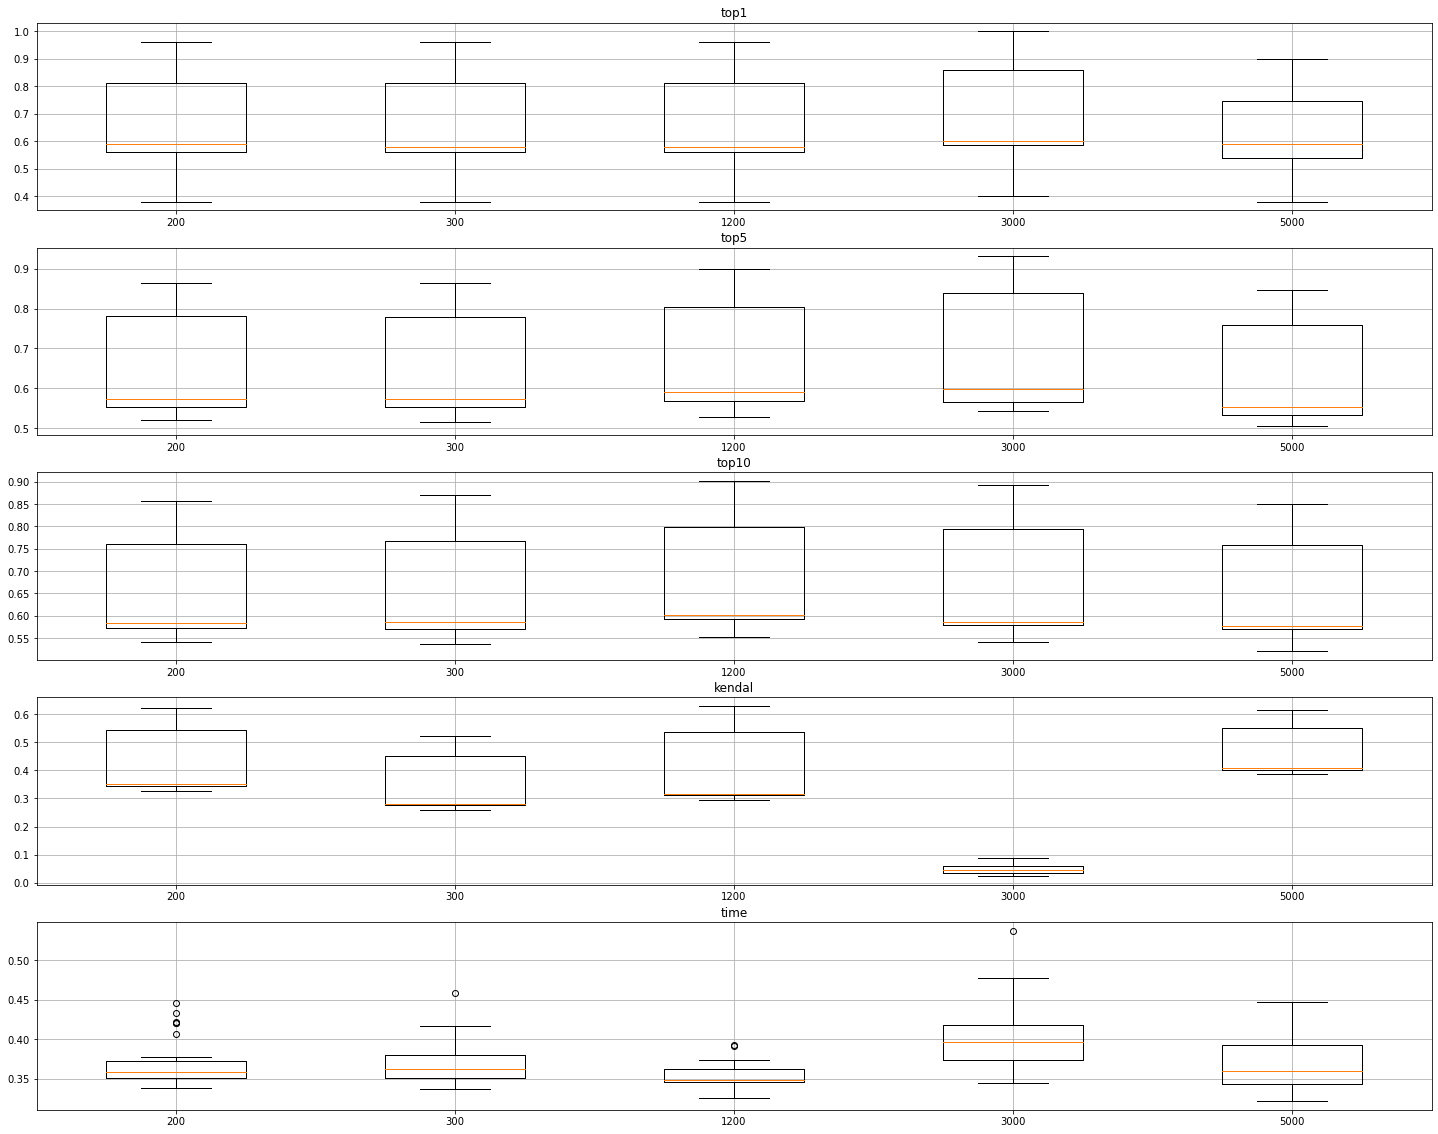

In [37]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    

# Baseline

In [115]:
G_nx = nx.readwrite.edgelist.read_edgelist(synthetic[0], delimiter="\t")
G_nk = nk.nxadapter.nx2nk(G_nx)
G_pyg = from_networkx(G_nx)

In [44]:
G_nx

In [34]:
G_nk

In [35]:
G_pyg

Data(edge_index=[2, 39964], x=[5000, 3])

In [82]:
G_pyg_ = to_data(synthetic[0], between[0])

In [84]:
G_pyg_.y

tensor([[9.4175e-02],
        [5.3971e-02],
        [4.4344e-02],
        ...,
        [1.9542e-05],
        [6.0578e-05],
        [1.0908e-04]], dtype=torch.float64)

In [ ]:
G_nx_ = G_pyg_

## RK (DIAM)

ApproxBetweenness

Fast approximation of betweenness centrality through sampling.

In [67]:
ab = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
ab.run()

In [80]:
ab.scores()

[0.10169491525423731,
 0.08851224105461396,
 0.06403013182674198,
 0.013182674199623353,
 0.039548022598870046,
 0.024482109227871935,
 0.011299435028248588,
 0.007532956685499058,
 0.02448210922787194,
 0.020715630885122408,
 0.01694915254237288,
 0.013182674199623353,
 0.0018832391713747645,
 0.005649717514124294,
 0.0018832391713747645,
 0.003766478342749529,
 0.007532956685499058,
 0.01694915254237288,
 0.0,
 0.015065913370998118,
 0.005649717514124294,
 0.003766478342749529,
 0.003766478342749529,
 0.003766478342749529,
 0.0,
 0.003766478342749529,
 0.009416195856873822,
 0.009416195856873822,
 0.0,
 0.0018832391713747645,
 0.003766478342749529,
 0.0018832391713747645,
 0.0,
 0.0018832391713747645,
 0.0018832391713747645,
 0.0,
 0.003766478342749529,
 0.0018832391713747645,
 0.0,
 0.007532956685499058,
 0.0,
 0.0,
 0.003766478342749529,
 0.005649717514124294,
 0.0,
 0.0018832391713747645,
 0.0,
 0.003766478342749529,
 0.003766478342749529,
 0.0018832391713747645,
 0.00188323917137

In [93]:
top_n_percentage(np.array(ab.scores()), G_pyg_.y, k=1)

0.3

In [96]:
kendal_tau_distance(np.array(ab.scores()), G_pyg_.y)

0.1908080408229779

### Synthetic

In [126]:
with open(os.path.join(setting.root, "rk.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## ABRA

Approximating betweenness centrality in static and dynamic graphs with rademacher averages

error tolerance λ to 0.01 and the probability δ to 0.1

## KADABRA

In [69]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8) 
kadabra.run() 

In [81]:
#The 10 most central nodes according to betweenness are then 
kadabra.scores()

[0.19547325102880658,
 0.1337448559670782,
 0.1748971193415638,
 0.037037037037037035,
 0.05555555555555555,
 0.03909465020576132,
 0.024691358024691357,
 0.01646090534979424,
 0.05555555555555555,
 0.0411522633744856,
 0.03292181069958848,
 0.00411522633744856,
 0.01440329218106996,
 0.026748971193415638,
 0.012345679012345678,
 0.01440329218106996,
 0.01440329218106996,
 0.018518518518518517,
 0.00823045267489712,
 0.030864197530864196,
 0.00205761316872428,
 0.01646090534979424,
 0.012345679012345678,
 0.00411522633744856,
 0.0,
 0.012345679012345678,
 0.012345679012345678,
 0.01646090534979424,
 0.006172839506172839,
 0.00823045267489712,
 0.00411522633744856,
 0.00823045267489712,
 0.0,
 0.00411522633744856,
 0.00823045267489712,
 0.0,
 0.012345679012345678,
 0.00205761316872428,
 0.0,
 0.00823045267489712,
 0.00205761316872428,
 0.00205761316872428,
 0.0,
 0.006172839506172839,
 0.00411522633744856,
 0.006172839506172839,
 0.0,
 0.00411522633744856,
 0.00411522633744856,
 0.0,
 0

In [90]:
top_n_percentage(np.array(kadabra.scores()), G_pyg_.y, k=500)

0.398

### Synthetic

In [128]:
with open(os.path.join(setting.root, "kadabra.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## K-BC (KPATH)

k-centralities: Local approximations of global measures based on shortest paths

For the value of k, we set it to be 20% of the diameter of the network

In [203]:
def KbcBetweenness(G, k):
    
    if k < 2:
        k = 2.0
        
    inf = float('inf')

    kBC = dict({key:0 for key in G.nodes()})
    for s in G.nodes():
        #Structures
        Q = deque() #Queue
        S = deque() #Stack
        dist = dict({key:inf for key in G.nodes()})
        sig = dict({key:float(0) for key in G.nodes()})
        pred = dict({key:[] for key in G.nodes()})

        #Initialize
        Q.append(s)
        dist[s] = 0
        sig[s] = 1

        #BFS - top-down
        while len(Q) > 0:
            v = Q.popleft()
            if dist[v] > k:
                break;
            S.append(v)
            for w in G[v]:
                if dist[w] == inf:
                    dist[w] = dist[v] + 1
                    if dist[w] <= k:
                        Q.append(w)
                if dist[w] == dist[v] + 1:
                    sig[w] += sig[v]
                    pred[w].append(v)
        #Aggregate - bottom-up
        delta = dict({key:float(0) for key in G.nodes()})
        while len(S) > 0:
            v = S.pop()
            for w in pred[v]:
                delta[w] += (delta[v]+1) * sig[w] / sig[v]
            if v!=s:
                if(G.is_directed()):
                    kBC[v] += delta[v]
                else: kBC[v] += delta[v] / 2.0

    return kBC

In [135]:
with open(os.path.join(setting.root, "kbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    for edge_list, score in zip(synthetic, between):
        
        
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        diameter = nx.algorithms.distance_measures.diameter(G_nx)
        start = time.time()
        result = KbcBetweenness(G_nx, diameter * 0.2)
        end = time.time()
        
        result = [v for k, v in sorted(result.items(), key=lambda  item: int(item[0]), reverse=False)]
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(result), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(result), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(result), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(result), G_pyg.y, k=10))
        
    json.dump(jsn, f)

/home/ai2019/ne6081064/anaconda3/envs/june/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/home/ai2019/ne6081064/anaconda3/envs/june/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


My time: 48.23896699999989
My time: 48.499878999999964
My time: 48.72280499999988
My time: 49.87856800000009
My time: 48.82277399999998
My time: 49.50401499999998
My time: 48.31838599999992
My time: 48.28031400000009
My time: 48.36628799999994
My time: 49.60768200000007
My time: 48.40837600000009
My time: 49.3982840000001
My time: 48.62930099999994
My time: 49.34602400000017
My time: 48.411427
My time: 49.23693599999979
My time: 48.39141399999971
My time: 48.93073999999979
My time: 48.11595400000033
My time: 49.2929750000003
My time: 48.79481299999998
My time: 49.92060300000003
My time: 48.04802299999983
My time: 49.5013100000001
My time: 48.45480499999985
My time: 49.32270699999981
My time: 48.81808099999989
My time: 49.76255899999978
My time: 48.78391999999985
My time: 48.893039000000044


In [210]:
G_pyg

Data(edge_index=[2, 39968], x=[5000, 3], y=[5000, 1])

## DrBC

In [200]:
with open(os.path.join(setting.root, "drbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    model.eval()
    model = model.to("cpu")
    for edge_list, score in zip(synthetic, between):
#         G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
#         G_nk = nk.nxadapter.nx2nk(G_nx)
        data = to_data(edge_list, score)
        
        start = time.time()
        bc_pr = model(data)
        end = time.time()

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
        jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
        jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
        jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))
        
    json.dump(jsn, f)

## Node2Vec

# Youtube

In [182]:
yt_nx = utils.to_networkx(yt_data, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)

In [183]:
yt_nx

In [185]:
from_networkx(yt_nx)

Data(edge_index=[2, 5975248], x=[1134890, 3])

In [209]:
with open(os.path.join(setting.root, "youtube.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    yt_pyg = to_data(yt[0], yt_score[0], y_sep=r":")
    yt_nx = utils.to_networkx(yt_pyg, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)
    yt_nk = nk.nxadapter.nx2nk(yt_nx)
    
    
    ### RK
    method = nk.centrality.ApproxBetweenness(yt_nk, epsilon=0.1)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nRK")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    ### Kadabra
    method = nk.centrality.KadabraBetweenness(yt_nk, 0.05, 0.8)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nKadabra")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    model.eval()
    start = time.time()
    bc_pr = model(yt_pyg)
    end = time.time()

    print("\nDrBC")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(bc_pr, yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=10)))

        
#     json.dump(jsn, f)


RK
time: 15.738577365875244
kendal: 0.07187868448005953
top 1: 0.2335213253436729
top 5: 0.3200514591851121
top 10: 0.3810413344024531

Kadabra
time: 1.2082817554473877
kendal: 0.20230506457754394
top 1: 0.49894254494184
top 5: 0.39290497673762864
top 10: 0.4057750090317123

DrBC
time: 99.74837827682495
kendal: -0.0983568872440969
top 1: 0.6009869580542827
top 5: 0.3065522345974905
top 10: 0.17317096811144692


KeyboardInterrupt: 

In [208]:
bc_pr.size()

torch.Size([5000, 1])

# Visualize all result

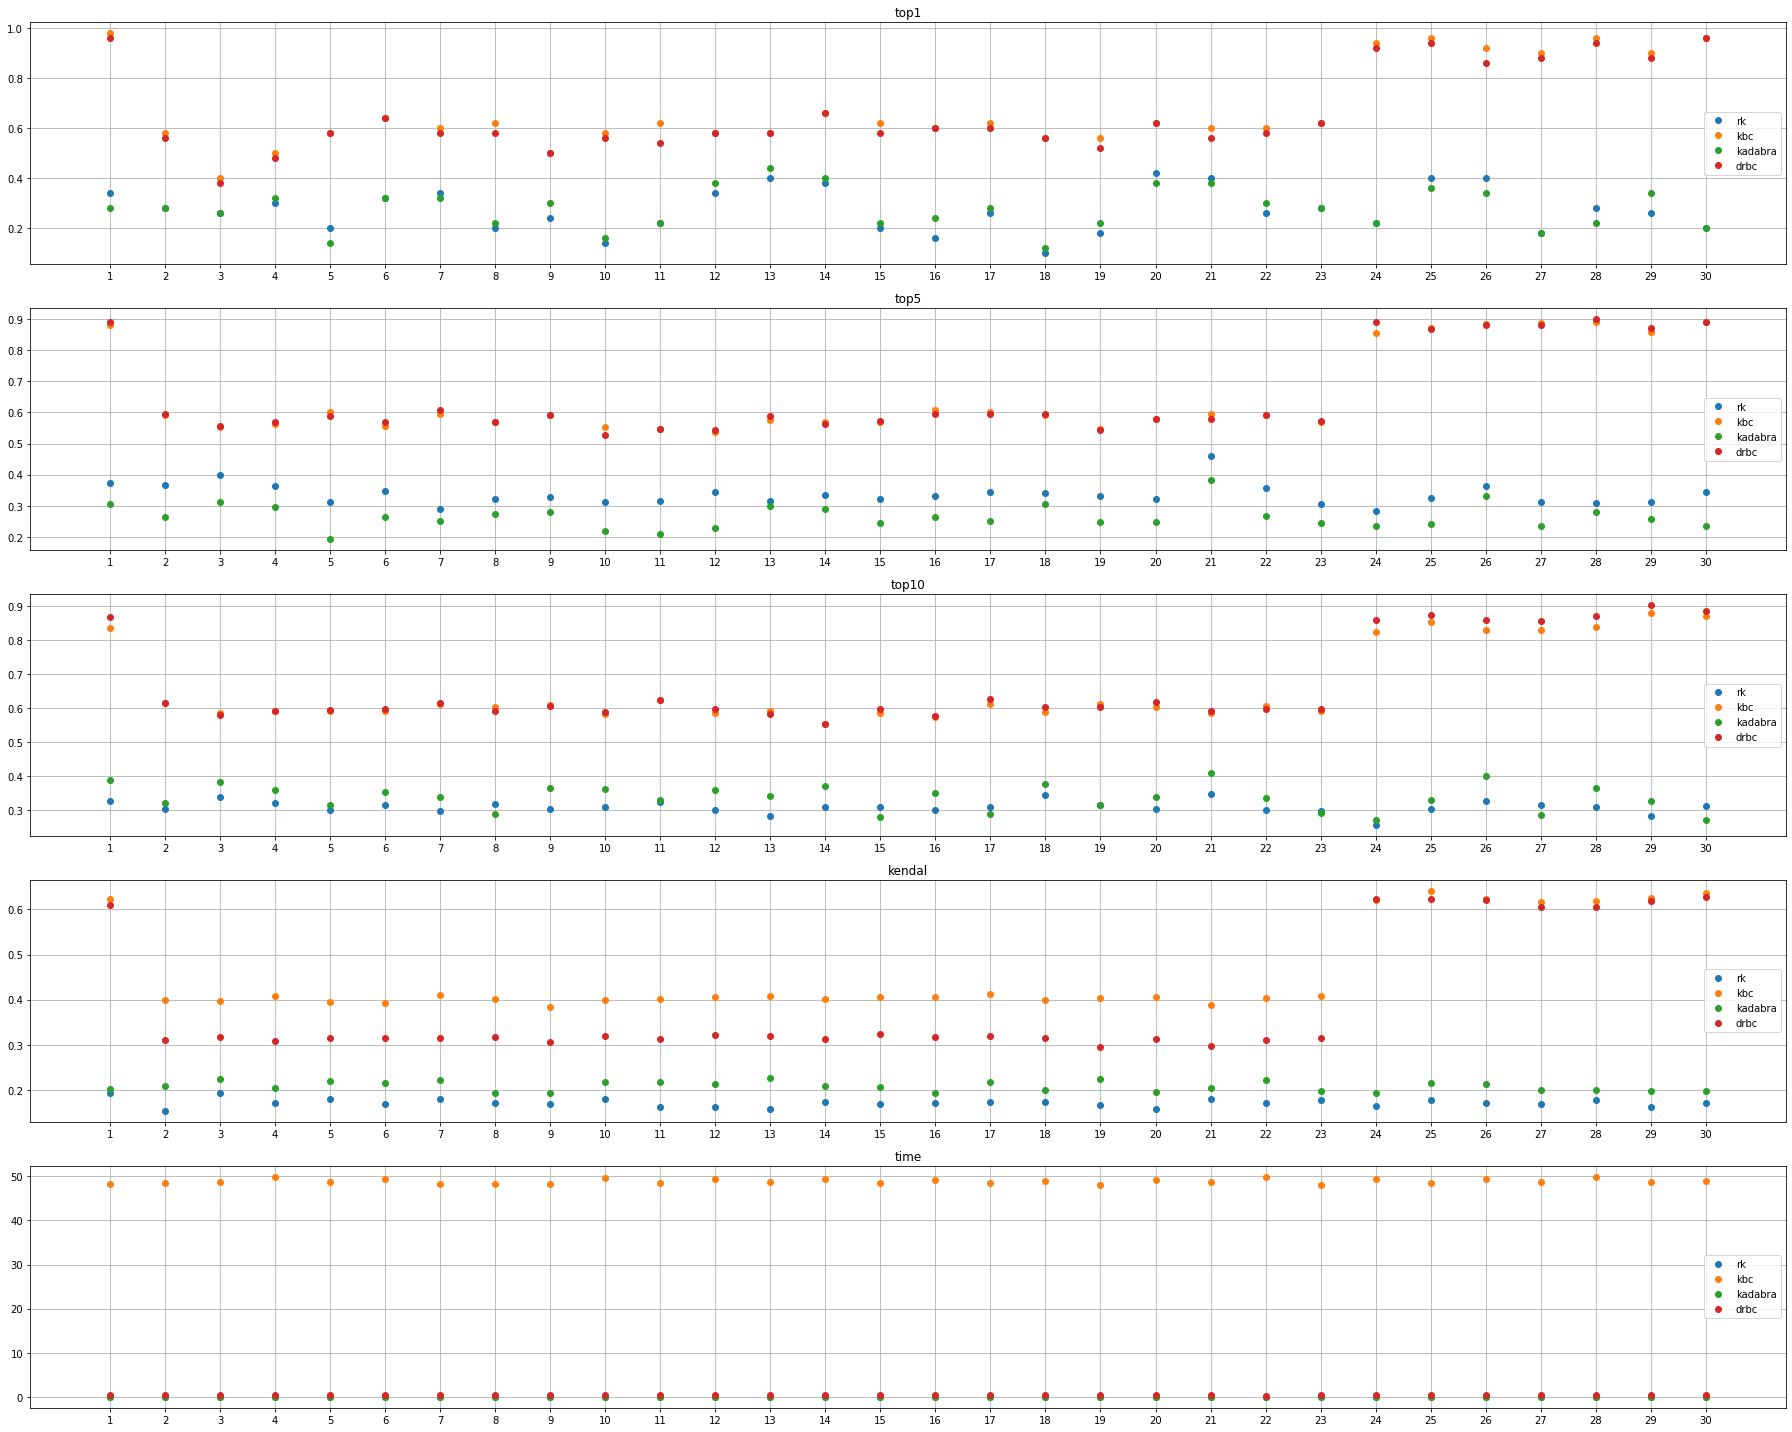

In [201]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())

    x = np.linspace(1, 30, 30)

    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        ax.plot(x, rk[key], "o")
        ax.plot(x, kbc[key], "o")
        ax.plot(x, kadabra[key], "o")
        ax.plot(x, drbc[key], "o")
        ax.legend(["rk", "kbc", "kadabra", "drbc"], loc='center right', bbox_to_anchor=(1, 0.5))

        ax.set_xticks(x)
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(os.path.join(setting.root, "synthetic_each.png"), facecolor="white")


top1
RK: mean=0.272, std=0.08572825283028539
KBC: mean=0.6786666666666668, std=0.16516120071682155
KADABRA: mean=0.27733333333333327, std=0.0792856999856987
DrBC: mean=0.66, std=0.16403251710153893

top5
RK: mean=0.33599999999999997, std=0.034176014981270125
KBC: mean=0.6558666666666667, std=0.13525081227934355
KADABRA: mean=0.2650666666666667, std=0.03835182162847317
DrBC: mean=0.6573333333333333, std=0.13822236513032984

top10
RK: mean=0.3092, std=0.018137254478007417
KBC: mean=0.6616666666666666, std=0.11151571887207451
KADABRA: mean=0.33713333333333334, std=0.03791106552035815
DrBC: mean=0.6700666666666667, std=0.12222763826383769

kendal
RK: mean=0.17120213356204778, std=0.009033669858847218
KBC: mean=0.4613863992828053, std=0.09934321546116276
KADABRA: mean=0.20803693144756413, std=0.010644902593383604
DrBC: mean=0.3943040288057612, std=0.13442441895633847

time
RK: mean=0.03280095259348551, std=0.0011003159685054455
KBC: mean=48.865695420900984, std=0.5439593463163784
KADABRA: 

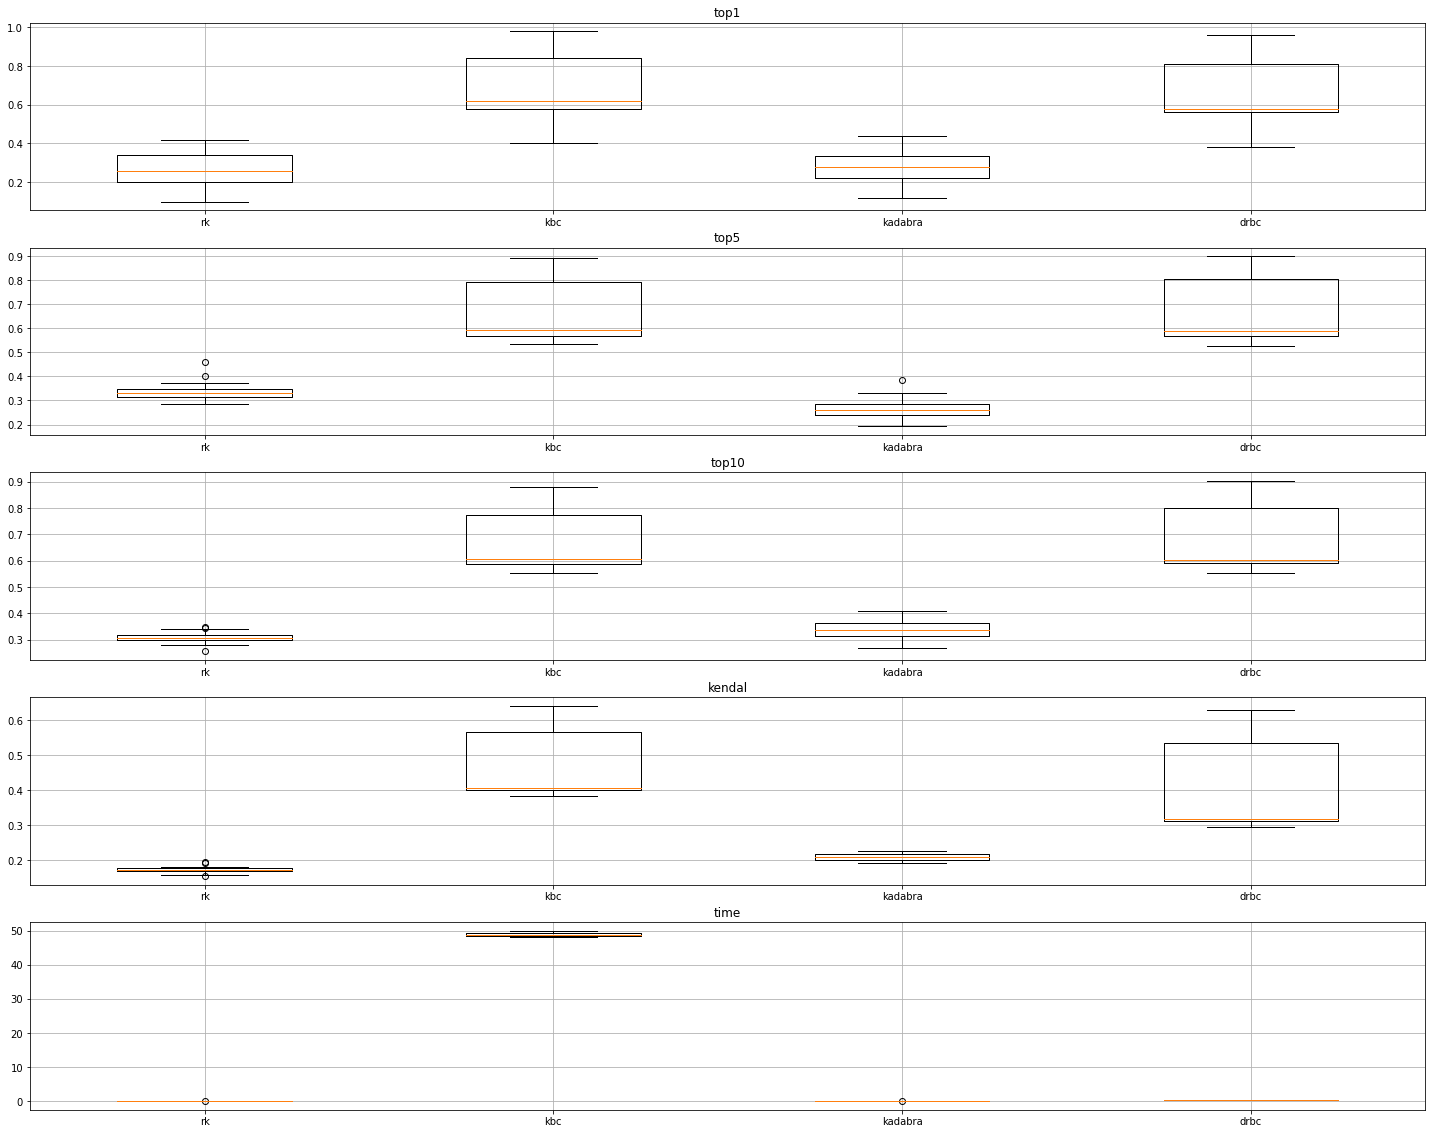

In [202]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([rk[key], kbc[key], kadabra[key], drbc[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        ### Calculate mean and std
        print("\n{}".format(key))
        rk_ = np.array(rk[key])
        print("RK: mean={}, std={}".format(np.mean(rk_), np.std(rk_)))
        
        kbc_ = np.array(kbc[key])
        print("KBC: mean={}, std={}".format(np.mean(kbc_), np.std(kbc_)))
        
        kadabra_ = np.array(kadabra[key])
        print("KADABRA: mean={}, std={}".format(np.mean(kadabra_), np.std(kadabra_)))
        
        drbc_ = np.array(drbc[key])
        print("DrBC: mean={}, std={}".format(np.mean(drbc_), np.std(drbc_)))
        
    
    plt.setp(axs,  xticklabels=['rk', 'kbc', 'kadabra', "drbc"])
    plt.savefig(os.path.join(setting.root, "synthetic_box.png"), facecolor="white")
    
    